In [1]:
#Pre-Processing of an image --

import cv2
import matplotlib.pyplot as plt
import numpy as np

def load_and_preprocess_image(image_path):
    # Load the image
    global image
    image = cv2.imread(image_path)
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Display the original and grayscale images for verification
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 2, 2)
    plt.title("Grayscale Image")
    plt.imshow(gray_image, cmap='gray')
    plt.show()
    
    return gray_image


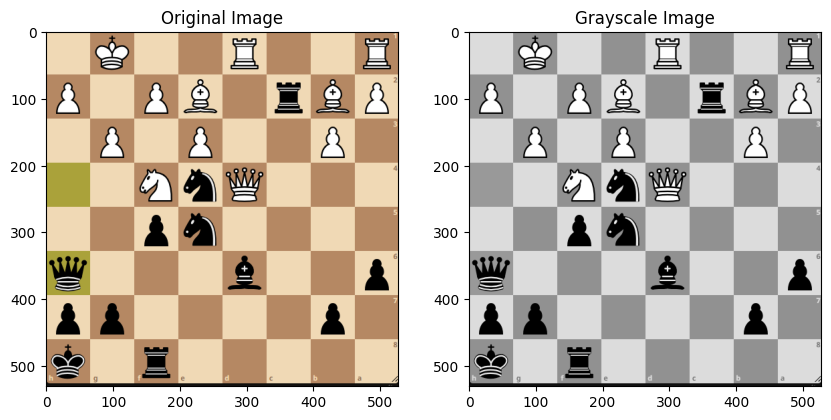

In [2]:
gray_image =load_and_preprocess_image(r'C:\Users\ASUS\FENgine\data\Position.PNG')

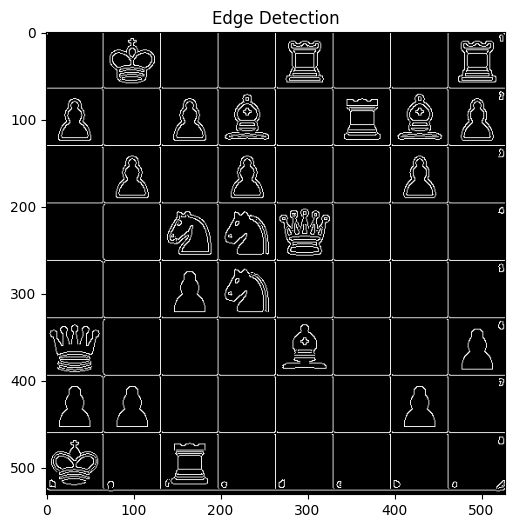

In [3]:
def detect_edges(image):
    # Apply Gaussian Blur to reduce noise and improve edge detection
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
    # Detect edges using Canny edge detection
    edges = cv2.Canny(blurred_image, threshold1=50, threshold2=150)
    
    # Display the edge-detected image
    plt.figure(figsize=(6, 6))
    plt.title("Edge Detection")
    plt.imshow(edges, cmap='gray')
    plt.show()
    
    return edges

# Example usage
edges = detect_edges(gray_image)

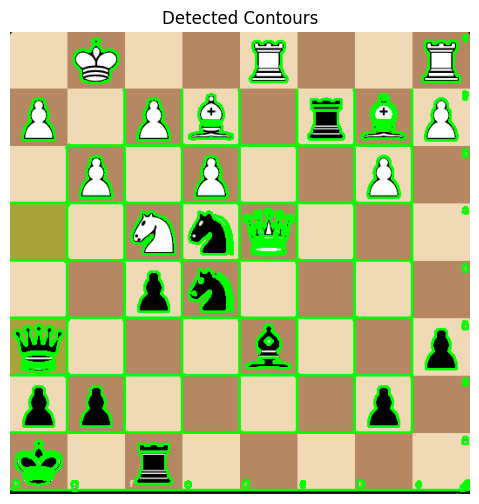

In [22]:
def find_chessboard_contours(edges, original_image):
    # Step 1: Find contours in the edge-detected image
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Step 2: Filter contours based on area to find the chessboard and pieces
    valid_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 2:  # Example area threshold, adjust as needed
            valid_contours.append(contour)

    # Step 3: Draw contours on the original image for visualization
    image_with_contours = original_image.copy()
    cv2.drawContours(image_with_contours, valid_contours, -1, (0, 255, 0), 2)  # Draw contours in green

    # Display the result
    plt.figure(figsize=(6, 6))
    plt.title("Detected Contours")
    plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Hide axes
    plt.show()
    
    return valid_contours

# Example usage
valid_contours = find_chessboard_contours(edges, image)
